In [1]:
!kaggle competitions download -c dogs-vs-cats

/bin/bash: kaggle: command not found


In [1]:
import zipfile
import os

zip_file = "dogs-vs-cats.zip"

dataset_directory = "./CatDog"

# dataset_zip = zipfile.ZipFile(zip_file)
# dataset_zip.extractall(dataset_directory)
# dataset_zip.close()

# train_zip = zipfile.ZipFile(os.path.join(dataset_directory, 'train.zip'))
# train_zip.extractall(dataset_directory)
# train_zip.close()

# test_zip = zipfile.ZipFile(os.path.join(dataset_directory, 'test1.zip'))
# test_zip.extractall(dataset_directory)
# test_zip.close()


In [2]:
train_dir = os.path.join(dataset_directory, 'train')
test_dir = os.path.join(dataset_directory, 'test1')

In [3]:
from collections import Counter, deque

label_count = Counter([name.split('.')[0] for name in os.listdir(train_dir)])
label_count

Counter({'dog': 12500, 'cat': 12500})

In [8]:
# make dataset

import torch as th
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision import io


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.image_names.sort()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        if th.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.image_names[idx])
        # image = io.read_image(img_name)
        image = np.array(Image.open(img_name))
        file_name = img_name.split('/')[-1]
        label = 1 if 'dog' in file_name else 0
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((500, 500)),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
    ]),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((500, 500)),
])


def get_data(train_dir, test_dir, train_transform=None, test_transform=None, batch_size=4):
    trainset = CustomDataset(train_dir, transform=train_transform)
    testset = CustomDataset(test_dir, transform=test_transform)
    
    val_size = int(len(trainset) * 0.2)
    valset, trainset = random_split(trainset, [val_size, len(trainset) - val_size])

    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
    validloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    return trainloader, validloader, testloader

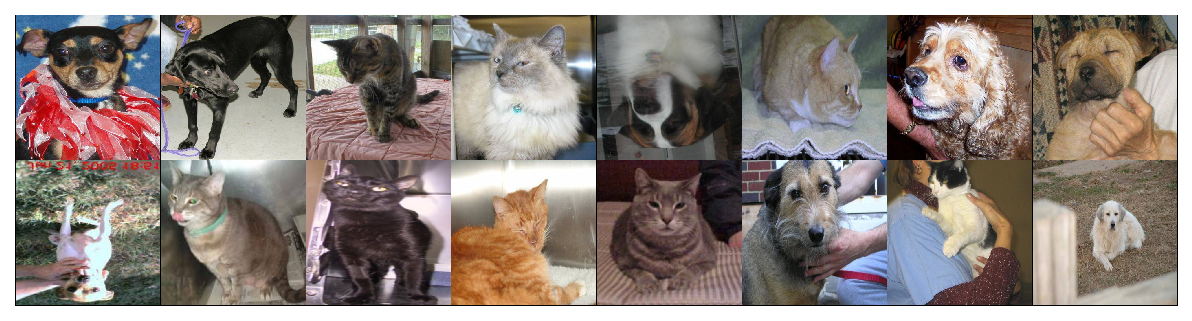

dog dog cat cat dog cat dog dog dog cat cat cat cat dog cat dog


In [10]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['image.interpolation'] = 'nearest'

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    

trainloader, validloader, testloader = get_data(train_dir, test_dir, train_transform=train_transform, test_transform=test_transform, batch_size=16)
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(utils.make_grid(images))
print(' '.join(f'{"dog" if label else "cat"}' for label in labels))

In [9]:
print(images.shape)
print(images[0])

torch.Size([16, 3, 500, 500])
tensor([[[0.4353, 0.5149, 0.6154,  ..., 0.7357, 0.7789, 0.8196],
         [0.5345, 0.5627, 0.6032,  ..., 0.8031, 0.8188, 0.8380],
         [0.5517, 0.5306, 0.5118,  ..., 0.7032, 0.7390, 0.7725],
         ...,
         [0.8392, 0.8412, 0.8445,  ..., 1.0000, 1.0000, 1.0000],
         [0.8392, 0.8424, 0.8470,  ..., 1.0000, 1.0000, 1.0000],
         [0.8392, 0.8374, 0.8363,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4353, 0.5202, 0.6272,  ..., 0.8214, 0.8695, 0.9137],
         [0.5492, 0.5794, 0.6223,  ..., 0.8887, 0.9094, 0.9321],
         [0.5990, 0.5780, 0.5597,  ..., 0.7923, 0.8331, 0.8702],
         ...,
         [0.9290, 0.9311, 0.9347,  ..., 1.0000, 1.0000, 1.0000],
         [0.9255, 0.9308, 0.9379,  ..., 1.0000, 1.0000, 1.0000],
         [0.9255, 0.9308, 0.9383,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.3961, 0.4686, 0.5599,  ..., 0.7753, 0.8181, 0.8588],
         [0.4916, 0.5094, 0.5373,  ..., 0.8387, 0.8524, 0.8698],
         [0.5015, 0.4730, 0.

In [17]:
# model = th.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
import torchvision
resnet = torchvision.models.resnet18(pretrained=True)
resnet

/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bluesun/anaconda3/envs/rl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
import torch.nn as nn
import torch.nn.functional as F

for param in resnet.parameters():
    param.requires_grad = False
    
resnet.fc = nn.Sequential(nn.Linear(512, 2),
                          nn.Softmax(dim=1))

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
import copy
from tqdm import tqdm

device = th.device("cuda:0" if th.cuda.is_available() else "cpu")

def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = th.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return 100 * correct / total


def train(trainloader, validloader, model, criterion, optimizer, epochs=10):
    model.to(device)
    
    accuracies = []
    losses = []
    max_accuracy = 0
    for epoch in range(epochs):
        running_loss = 0.0
        tqdm_iter = tqdm(enumerate(trainloader), total=len(trainloader))
        for i, data in tqdm_iter:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tqdm_iter.desc = f'Epoch {epoch + 1} loss: {running_loss / (i + 1):.4f}'
            
        accuracy = evaluation(validloader, model)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(model)
            max_accuracy = accuracy
            print(f'New best model with accuracy {max_accuracy}')

        accuracies.append(accuracy)
        losses.append(running_loss / len(trainloader))

        print(f'Epoch {epoch + 1} accuracy: {accuracy}, loss: {running_loss / (i + 1)}')
    print('Finished Training')
    
    return best_model, accuracies, losses

In [20]:
model, accuracies, losses = train(trainloader, validloader, model=resnet,
                                  criterion=nn.CrossEntropyLoss(),
                                  optimizer=th.optim.Adam(resnet.parameters(), lr=0.001),
                                  epochs=5)

100%|██████████| 1250/1250 [00:40<00:00, 31.07it/s]


New best model with accuracy 91.16
Epoch 1 accuracy: 91.16, loss: 0.42512206349372866


100%|██████████| 1250/1250 [00:40<00:00, 30.53it/s]


New best model with accuracy 91.3
Epoch 2 accuracy: 91.3, loss: 0.39263646488189696


100%|██████████| 1250/1250 [00:40<00:00, 30.90it/s]


Epoch 3 accuracy: 91.04, loss: 0.38682739691734314


100%|██████████| 1250/1250 [00:40<00:00, 31.01it/s]


New best model with accuracy 92.7
Epoch 4 accuracy: 92.7, loss: 0.38456650314331053


100%|██████████| 1250/1250 [00:40<00:00, 30.86it/s]


New best model with accuracy 92.92
Epoch 5 accuracy: 92.92, loss: 0.38243275520801545
Finished Training


In [42]:
def predict(images, model):
    model.eval()
    model.to(device)
    images = images.to(device)
    outputs = model(images)
    _, predicted = th.max(outputs, 1)
    return predicted

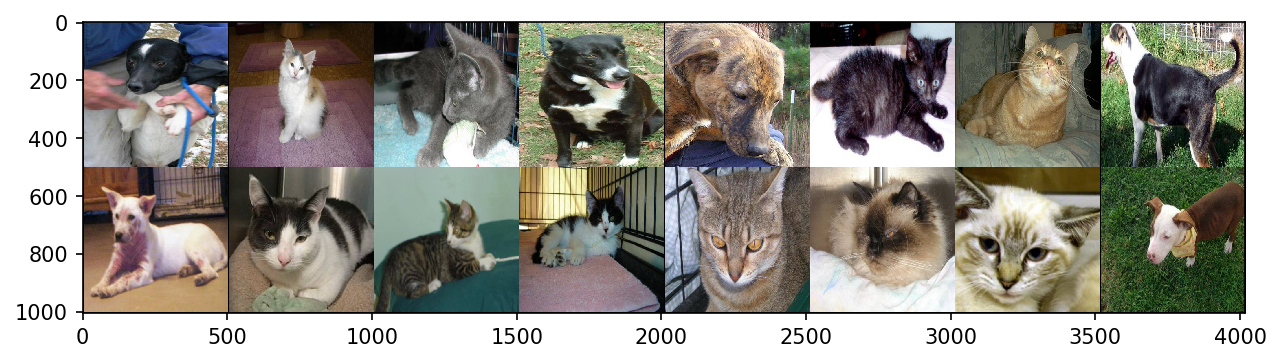

dog cat cat dog dog cat cat dog dog cat cat cat cat cat cat dog


In [54]:
testiter = iter(testloader)
images, labels = next(testiter)

imshow(utils.make_grid(images))
pred = predict(images, model).cpu().numpy()
print(' '.join(f'{"dog" if label else "cat"}' for label in pred))

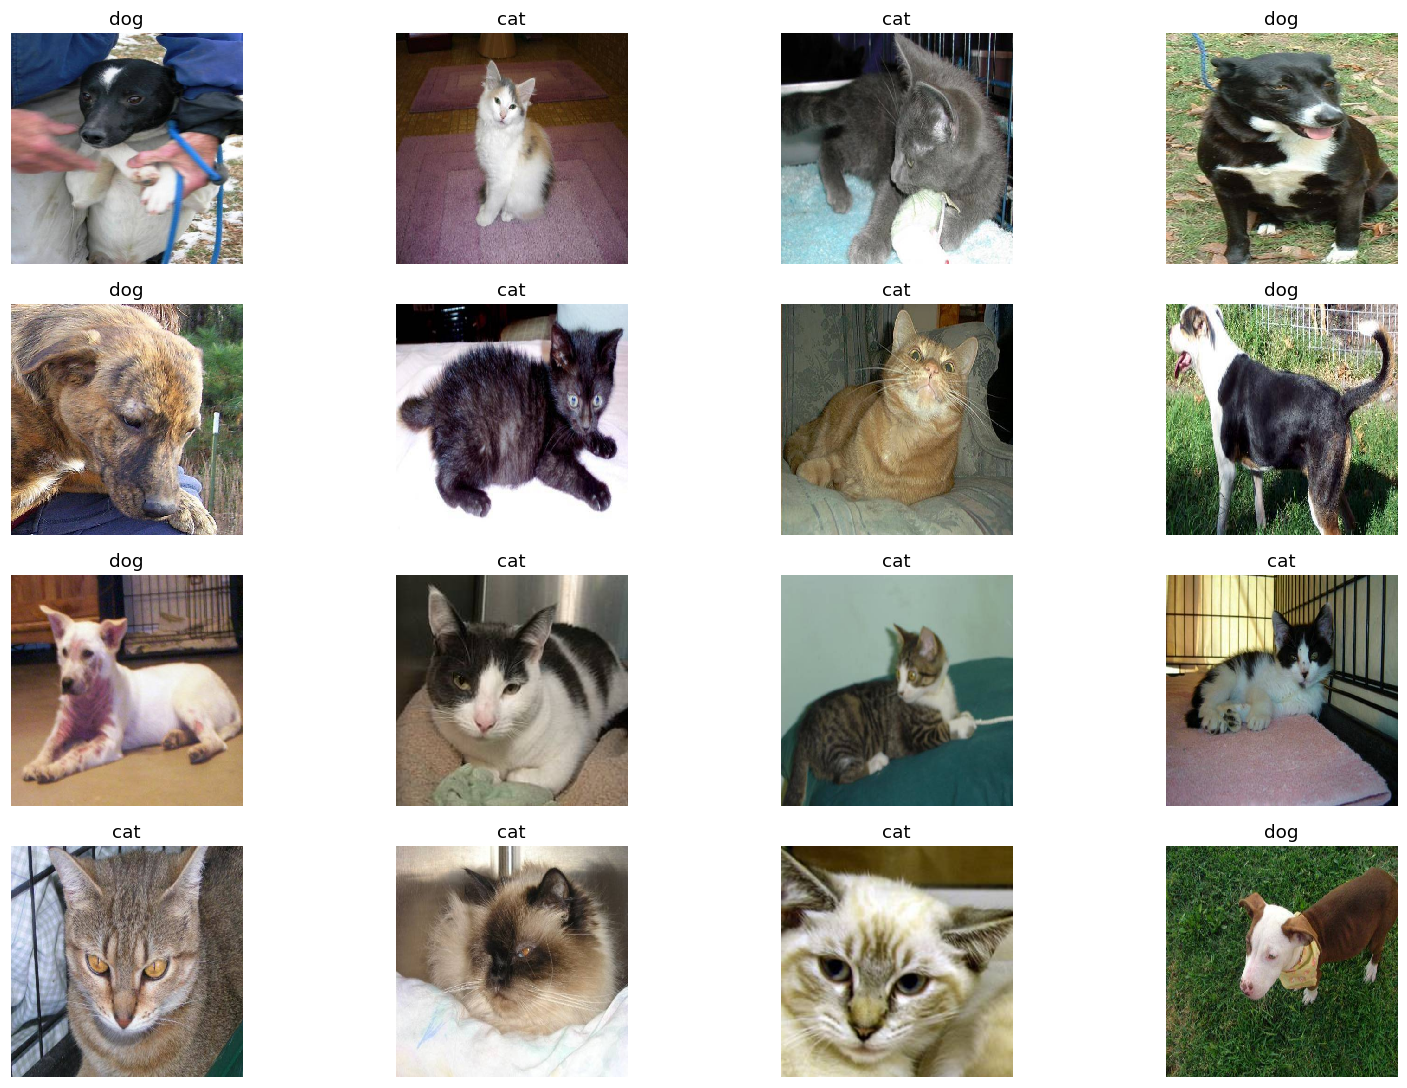

In [53]:
images = next(iter(testloader))[0]
pred = predict(images, model).cpu().numpy()

fig = plt.figure(figsize=(15, 10), dpi=110)
for i, image in enumerate(images):
    ax = fig.add_subplot(4, 4, i + 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'{"dog" if pred[i] else "cat"}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

patch = Circle((0, 0), radius=1, fill=True)
ax.add_patch(patch)

def update(frame):
    if frame <= 100:
        patch.radius = 1 - frame / 100
    else:
        patch.set_visible(False)
        rect = Rectangle((-0.5, -0.5), 1, 1, fill=True)
        ax.add_patch(rect)

ani = FuncAnimation(fig, update, frames=200, interval=20)
plt.show()